In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np
import logging
from datetime import datetime
from funs import *


log("START",level = ("start","Isolation_forest"))

# DEFINE TYPE OF DATA PARSNG
min_parsed = False
with_repetitions = False
tuned = True


Isolation_forest


<div style="
    text-align: center;
    font-weight: bold;
    font-size: 52px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-top: 50px;
    margin-bottom: 30px;
    padding: 25px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    border-top: 4px solid #4ec9b0;
    border-bottom: 4px solid #4ec9b0;
    box-shadow: 0 0 100px rgba(78, 201, 176, 0.3), 0 2px 10px rgba(0,0,0,0.6);
    letter-spacing: 1px;
">
  Przygotowanie danych
</div>


<div style="text-align: center; font-weight: bold; font-size: 35px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 30px; margin-bottom: 20px; padding: 10px 0; border-top: 2px solid #666; border-bottom: 2px solid #666;">
  Przygotowania danych normalnego ruchu do trenowania modelu
</div>

<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
<ul style="margin-left: 20px;">
    1. df_1 – Monday-WorkingHours.pcap_ISCX.csv
  </ul>
</div>


In [2]:
# Wczytanie danych
df_1 = pd.read_csv("../datasets/CIC-IDS2017/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv", low_memory=False)
print("Lenght of dataframe befour preperation: ")
print(len(df_1))

df_1.columns = df_1.columns.str.strip()
print("Droping Lable and redundancy")

if(min_parsed):
    keep_columns = True
    repetition_rows = True
elif(with_repetitions):
    keep_columns = False
    repetition_rows = True
elif(tuned):
    keep_columns = False
    repetition_rows = False
    
###############################################              1
if(keep_columns == False):
    columns_to_keep = [
        'Bwd Packet Length Max',
        'Bwd Packet Length Mean',
        'Bwd Packet Length Std',
        'Flow Bytes/s',
        'Flow Duration',
        'Flow IAT Max',
        'Flow IAT Mean',
        'Flow IAT Min',
        'Flow IAT Std',
        'Fwd IAT Total',
        'Fwd Packet Length Max',
        'Fwd Packet Length Mean',
        'Fwd Packet Length Min',
        'Fwd Packet Length Std',
        'Total Backward Packets',
        'Total Fwd Packets',
        'Total Length of Bwd Packets',
        'Total Length of Fwd Packets',
        'Label',
        "Fwd Header Length.1",
    ]
    
    # Drop columns NOT in columns_to_keep (inplace)
    cols_to_drop = [col for col in df_1.columns if col not in columns_to_keep]
    df_1.drop(columns=cols_to_drop, inplace=True)

###############################################              1
    
df_1.drop(["Fwd Header Length.1", "Label"], axis=1, inplace=True)


print("Number of NANS")
print(df_1.isna().any(axis=1).sum())
##########################################################################################              2
# #BEZ POWTARZAJĄCYCH SIĘ KOLUMN
# Count duplicate rows and add a column 'Repetition num' with the count
if(repetition_rows == False):
    df_counts = df_1.groupby(list(df_1.columns)).size().reset_index(name='Repetition num')
    
    # Replace original df with grouped version (deduplicated with repetition count)
    df_1.drop(df_1.index, inplace=True)  # Clear existing rows in df
    for col in df_counts.columns:
        df_1[col] = df_counts[col].values  # Fill df with new data

# Z POWTARZAJĄCYMI SIĘ FLOWAMI I KOLUMNOM POWTOZEN
else:
    repetition_counts = (
        df_1.groupby(df_1.columns.tolist())
        .size()
        .rename("Repetition num")
        .reset_index()
    )
    
    df_1["Repetition num"] = df_1.merge(
        repetition_counts, 
        on=df_1.columns.tolist(), 
        how="left"
    )["Repetition num"]




num_cols = df_1.select_dtypes(include=[np.number]).columns
inf_mask = np.isinf(df_1[num_cols])
columns_with_inf = df_1.columns[inf_mask.any()]
print("Colums with inf: ")
print(columns_with_inf.tolist())

df_1.replace([np.inf, -np.inf], np.nan, inplace=True)

print("Number of NANS and infs: ")
print(df_1.isna().any(axis=1).sum())
df_1.dropna(inplace=True)
df_1 = df_1.reset_index(drop=True)
print("Lenght of dataframe after preperation: ")
print(len(df_1))




Lenght of dataframe befour preperation: 
529918
Droping Lable and redundancy
Number of NANS
64
Colums with inf: 
['Flow Bytes/s']
Number of NANS and infs: 
13
Lenght of dataframe after preperation: 
400676


<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>1.2 Skalowanie danych treningowych</div>
</div>

In [3]:
scaler = StandardScaler()
df_1_scaled = pd.DataFrame(
    scaler.fit_transform(df_1),
    columns=df_1.columns  
)

<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>1.3 Skalowanie danych - wizualizacja dzialania skalowania</div>
</div>

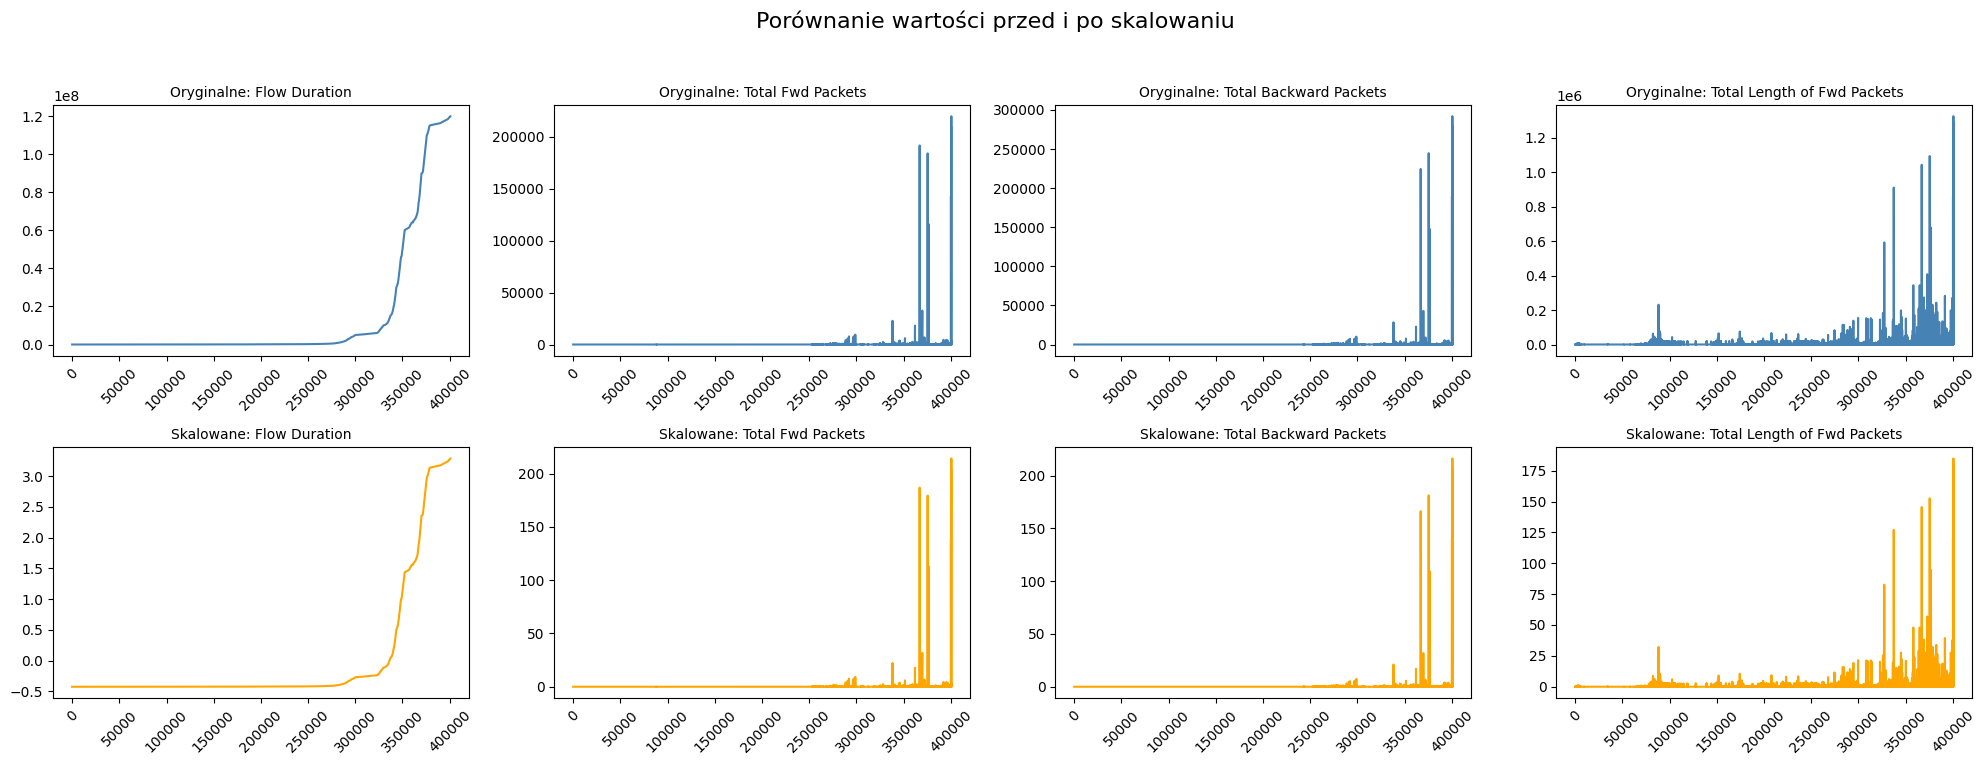

Series([], Name: Total Fwd Packets, dtype: float64)
Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total',
       'Repetition num'],
      dtype='object')


In [4]:
columns_to_plot = df_1.columns[:4]

# Ustawienia siatki 2x4 (2 wiersze: oryginał, skalowane)
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Porównanie wartości przed i po skalowaniu", fontsize=16)

for i, col in enumerate(columns_to_plot):
    # Oryginalne dane - wykres liniowy
    axes[0, i].plot(df_1[col].values, color='steelblue')
    axes[0, i].set_title(f"Oryginalne: {col}", fontsize=10)
    axes[0, i].tick_params(axis='x', rotation=45)

    # Skalowane dane - wykres liniowy
    axes[1, i].plot(df_1_scaled[col].values, color='orange')
    axes[1, i].set_title(f"Skalowane: {col}", fontsize=10)
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(df_1_scaled[df_1_scaled["Total Fwd Packets"] > 500]["Total Fwd Packets"])
print(df_1_scaled.columns)


<div style="text-align: center; font-weight: bold; font-size: 35px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 30px; margin-bottom: 20px; padding: 10px 0; border-top: 2px solid #666; border-bottom: 2px solid #666;">
  Przygotowanie dataframe'ów testowych zawierająch różne ataki
</div>



<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <li>2. Przygotowanie danych z Tuesday-WorkingHours.pcap_ISCX.csv</li>
    <ul style="margin-left: 15px;">
        <li>df_2 - dane "Tuesday-WorkingHours"</li>
        <li>df_2_5 - dane "Tuesday-WorkingHours" tylko z atakami</li>
    </ul>
</div>

In [5]:
df_2 = pd.read_csv("../datasets/CIC-IDS2017/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv", low_memory=False)

if(min_parsed):
    df_2_labels, df_2_5 = prep_df(df_2,labels = True, only_a = True, rep = True, keep_col = True)
elif(with_repetitions):
    df_2_labels, df_2_5 = prep_df(df_2,labels = True, only_a = True, rep = True, keep_col = False)
elif(tuned):
    df_2_labels, df_2_5 = prep_df(df_2,labels = True, only_a = True, rep = False, keep_col = False)
    

print(df_2.columns)

Number of flows:  445909
Number of flows with NAN:  201
Number of flows with inf or -inf :  63
Number of flows labled as Attac:  13835
264 Flows deleted 
Number flows in after preparation :  342225
Number of flows labled as Attac after preperation:  9084

Creating df with everything that is labled having an attac
number of flows in Attac only dataframe :  9084
Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total',
       'Repetition num'],
      dtype='object')


<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <li>3. Przygotowanie danych z Wednesday-WorkingHours.pcap_ISCX.csv</li>
    <ul style="margin-left: 15px;">
        <li>df_3 - dane "Wednesday-WorkingHours"</li>
        <li>df_3_5 - dane "Wednesday-WorkingHours" tylko z różnymi atakami</li>
    </ul>
</div>

In [6]:
df_3 = pd.read_csv("../datasets/CIC-IDS2017/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv", low_memory=False)

if(min_parsed):
    df_3_labels, df_3_5 = prep_df(df_3,labels = True, only_a = True, rep = True, keep_col = True)
elif(with_repetitions):
    df_3_labels, df_3_5 = prep_df(df_3,labels = True, only_a = True, rep = True, keep_col = False)
elif(tuned):
    df_3_labels, df_3_5 = prep_df(df_3,labels = True, only_a = True, rep = False, keep_col = False)
    


Number of flows:  692703
Number of flows with NAN:  1008
Number of flows with inf or -inf :  289
Number of flows labled as Attac:  252672
1297 Flows deleted 
Number flows in after preparation :  537297
Number of flows labled as Attac after preperation:  192878

Creating df with everything that is labled having an attac
number of flows in Attac only dataframe :  192878


<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <li>4. Przygotowanie danych z czwartku df_4:</li>
    <ul style="margin-left: 15px;">
        <li> df_4_1 - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv</li>
    </ul>
</div>

In [7]:
df_4_1 = pd.read_csv("../datasets/CIC-IDS2017/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", low_memory=False)

if(min_parsed):
    df_4_1_labels = prep_df(df_4_1,labels = True, rep = True, keep_col = True)
elif(with_repetitions):
    df_4_1_labels = prep_df(df_4_1,labels = True, rep = True, keep_col = False)
elif(tuned):
    df_4_1_labels = prep_df(df_4_1,labels = True, rep = False, keep_col = False)

Number of flows:  170366
Number of flows with NAN:  20
Number of flows with inf or -inf :  115
Number of flows labled as Attac:  2180
135 Flows deleted 
Number flows in after preparation :  137893
Number of flows labled as Attac after preperation:  2099


<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <ul style="margin-left: 15px;">
        <li>  df_4_2 - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX & df_4 = df_4_1 + df_4_2</li>
    </ul>
</div>

In [8]:
df_4_2 = pd.read_csv("../datasets/CIC-IDS2017/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", low_memory=False)

if(min_parsed):
    df_4_2_labels = prep_df(df_4_2,labels = True, rep = True, keep_col = True)
elif(with_repetitions):
    df_4_2_labels = prep_df(df_4_2,labels = True, rep = True, keep_col = False)
elif(tuned):
    df_4_2_labels = prep_df(df_4_2,labels = True, rep = False, keep_col = False)

df_4 = pd.concat([df_4_1,df_4_2], ignore_index = True)
df_4_labels = pd.concat([df_4_1_labels,df_4_2_labels], ignore_index = True)

print("Flows during the day: ", len(df_4), len(df_4_labels))

Number of flows:  288602
Number of flows with NAN:  18
Number of flows with inf or -inf :  189
Number of flows labled as Attac:  36
207 Flows deleted 
Number flows in after preparation :  183082
Number of flows labled as Attac after preperation:  36
Flows during the day:  320975 320975


<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <li>5. Przygotowanie danych z piątku df_4:</li>
    <ul style="margin-left: 15px;">
        <li> df_5_1 - Friday-WorkingHours-Morning.pcap_ISCX</li>
    </ul>
</div>

In [9]:
df_5_1 = pd.read_csv("../datasets/CIC-IDS2017/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv", low_memory=False)

if(min_parsed):
    df_5_1_labels = prep_df(df_5_1,labels = True, rep = True, keep_col = True)
elif(with_repetitions):
    df_5_1_labels = prep_df(df_5_1,labels = True, rep = True, keep_col = False)
elif(tuned):
    df_5_1_labels = prep_df(df_5_1,labels = True, rep = False, keep_col = False)

Number of flows:  191033
Number of flows with NAN:  28
Number of flows with inf or -inf :  94
Number of flows labled as Attac:  1966
122 Flows deleted 
Number flows in after preparation :  156351
Number of flows labled as Attac after preperation:  1337


<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <ul style="margin-left: 15px;">
        <li>  df_5_2 - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX</li>
    </ul>
</div>

In [10]:
df_5_2 = pd.read_csv("../datasets/CIC-IDS2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", low_memory=False)

if(min_parsed):
    df_5_2_labels = prep_df(df_5_2,labels = True, rep = True, keep_col = True)
elif(with_repetitions):
    df_5_2_labels = prep_df(df_5_2,labels = True, rep = True, keep_col = False)
elif(tuned):
    df_5_2_labels = prep_df(df_5_2,labels = True, rep = False, keep_col = False)

print(df_5_2.isna().any(axis=1).sum())

Number of flows:  286467
Number of flows with NAN:  15
Number of flows with inf or -inf :  356
Number of flows labled as Attac:  158930
371 Flows deleted 
Number flows in after preparation :  105591
Number of flows labled as Attac after preperation:  1923
0


<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <ul style="margin-left: 15px;">
        <li>  df_5_3 - Friday-WorkingHours-Afternoon-DDos & df_5 = df_5_1 + df_5_2 + df_5_3</li>
    </ul>
</div>

In [11]:
df_5_3 = pd.read_csv("../datasets/CIC-IDS2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", low_memory=False)

if(min_parsed):
    df_5_3_labels = prep_df(df_5_3,labels = True, rep = True, keep_col = True)
elif(with_repetitions):
    df_5_3_labels = prep_df(df_5_3,labels = True, rep = True, keep_col = False)
elif(tuned):
    df_5_3_labels = prep_df(df_5_3,labels = True, rep = False, keep_col = False)

df_5 = pd.concat([df_5_1,df_5_2,df_5_3], ignore_index = True)
df_5_labels = pd.concat([df_5_1_labels,df_5_2_labels,df_5_3_labels], ignore_index = True)
print("Flows during the day: ", len(df_5),len(df_5_labels))

Number of flows:  225745
Number of flows with NAN:  4
Number of flows with inf or -inf :  30
Number of flows labled as Attac:  128027
34 Flows deleted 
Number flows in after preparation :  214554
Number of flows labled as Attac after preperation:  128013
Flows during the day:  476496 476496


<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>4. Skalowanie danych:</div>

</div>

In [12]:

df_2_scaled = pd.DataFrame(
    scaler.transform(df_2),
    columns=df_2.columns  
)


df_2_5_scaled = pd.DataFrame(
    scaler.transform(df_2_5),
    columns=df_2_5.columns  
)

df_3_scaled = pd.DataFrame(
    scaler.transform(df_3),
    columns=df_3.columns  
)


df_3_5_scaled = pd.DataFrame(
    scaler.transform(df_3_5),
    columns=df_3_5.columns  
)

df_4_scaled = pd.DataFrame(
    scaler.transform(df_4),
    columns=df_4.columns  
)

df_5_scaled = pd.DataFrame(
    scaler.transform(df_5),
    columns=df_5.columns  
)

print(df_3_scaled.isna().any(axis=1).sum())

0


<div style="
    text-align: center;
    font-weight: bold;
    font-size: 52px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-top: 50px;
    margin-bottom: 30px;
    padding: 25px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    border-top: 4px solid #4ec9b0;
    border-bottom: 4px solid #4ec9b0;
    box-shadow: 0 0 100px rgba(78, 201, 176, 0.3), 0 2px 10px rgba(0,0,0,0.6);
    letter-spacing: 1px;
">
   Isolation forest - algorytm  wykrywania anomali
</div>


<div style="text-align: center; font-weight: bold; font-size: 35px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 30px; margin-bottom: 20px; padding: 10px 0; border-top: 2px solid #666; border-bottom: 2px solid #666;">
 1. Trenowanie na normalnym ruchu
</div>

In [13]:
IF = IsolationForest(
    n_estimators=250,
    max_samples=8192, 
    contamination= 0.01, #PRAKTYCZNIE NIE ISTOTNE DO PRZEWIDYWAN MODELU, ISTOTNE TYLKO PRZY ZWRACANIU WYNIKOW ZE STATYSTYK
    max_features=1.0, 
    bootstrap=False, 
    n_jobs=None, 
    random_state=33, 
    verbose=1, 
    warm_start=False
)
params_str = '\n'.join(f'{k}: {v}' for k, v in IF.get_params().items())
log("Parametry modelu:\n" + params_str)

IF.fit(df_1_scaled)

Parametry modelu:
bootstrap: False
contamination: 0.01
max_features: 1.0
max_samples: 8192
n_estimators: 250
n_jobs: None
random_state: 33
verbose: 1
warm_start: False


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    3.9s finished


,n_estimators,250
,max_samples,8192
,contamination,0.01
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,33
,verbose,1
,warm_start,False


<div style="text-align: center; font-weight: bold; font-size: 35px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 30px; margin-bottom: 20px; padding: 10px 0; border-top: 2px solid #666; border-bottom: 2px solid #666;">
 Testy na danych
</div>


<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>2.1 Wizualizacja efektu testu na danych Tuesday-workingHours Atacks pnly</div>
</div>

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished



 Detection distribution anomaly/normal: 0.0220% / 99.9780%
!!! Wyniki pokazuje dopasowanie contamination (wyciagancia wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected:  2
Normal traffic:  9082


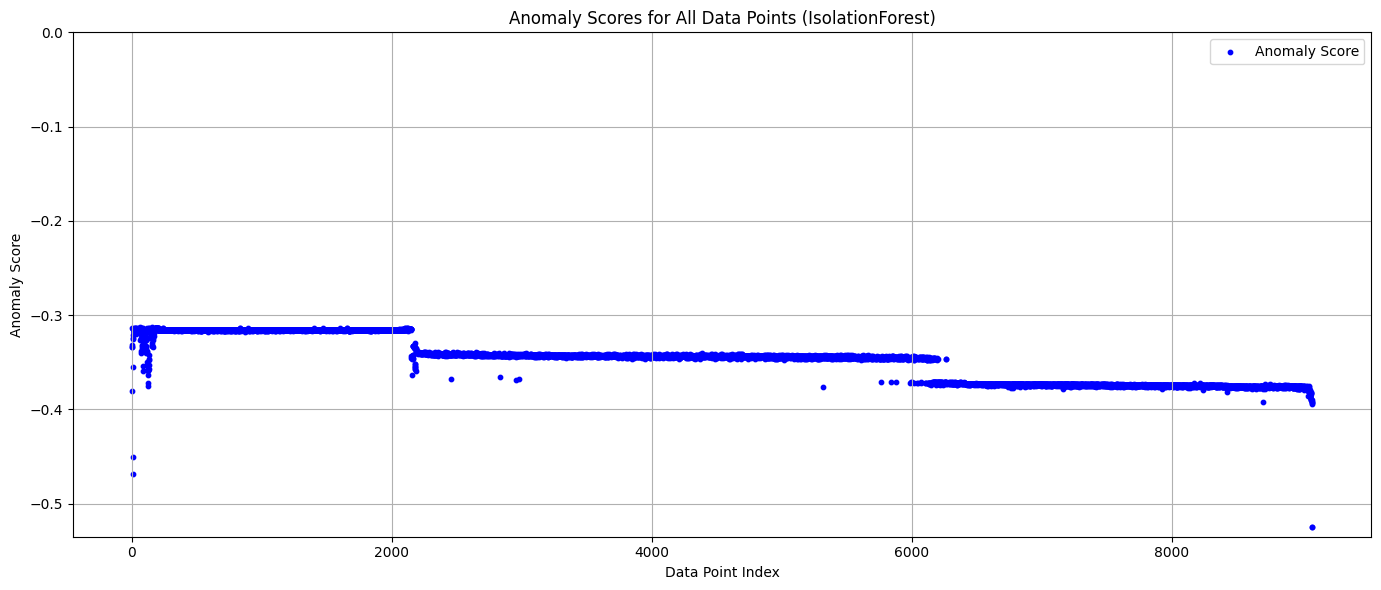

In [14]:
preds_2_5 = IF.predict(df_2_5_scaled)
scores_2_5 = IF.score_samples(df_2_5_scaled)

df_2_5_scaled_result = pd.DataFrame()
df_2_5_scaled_result['prediction'] = preds_2_5
df_2_5_scaled_result['anomaly_score'] = scores_2_5


anomaly_2_5 = (df_2_5_scaled_result["prediction"] == -1).sum()
normal_2_5 = (df_2_5_scaled_result["prediction"] == 1).sum()

print("\n" , f"Detection distribution anomaly/normal: {anomaly_2_5 / len(df_2_5_scaled_result) * 100:.4f}% / {normal_2_5 / len(df_2_5_scaled_result) * 100:.4f}%")
print("!!! Wyniki pokazuje dopasowanie contamination (wyciagancia wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!")
print("Anomaly detected: ",anomaly_2_5)
print("Normal traffic: ",normal_2_5)
plt.figure(figsize=(14, 6))

plt.scatter(df_2_5_scaled_result.index, df_2_5_scaled_result['anomaly_score'], color='blue', label='Anomaly Score', s=10)

plt.title('Anomaly Scores for All Data Points (IsolationForest)')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(top=0)
plt.show()


<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>2.2 Wizualizacja efektu testu na danych Tuesday-workingHours</div>
</div>

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    3.3s finished


Isolation_forest
Detection distribution anomaly/normal: 1.2071% / 98.7929%
!!! Wyniki pokazuje dopasowanie contamination (wyciagania wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected: 4131
Normal traffic: 338094


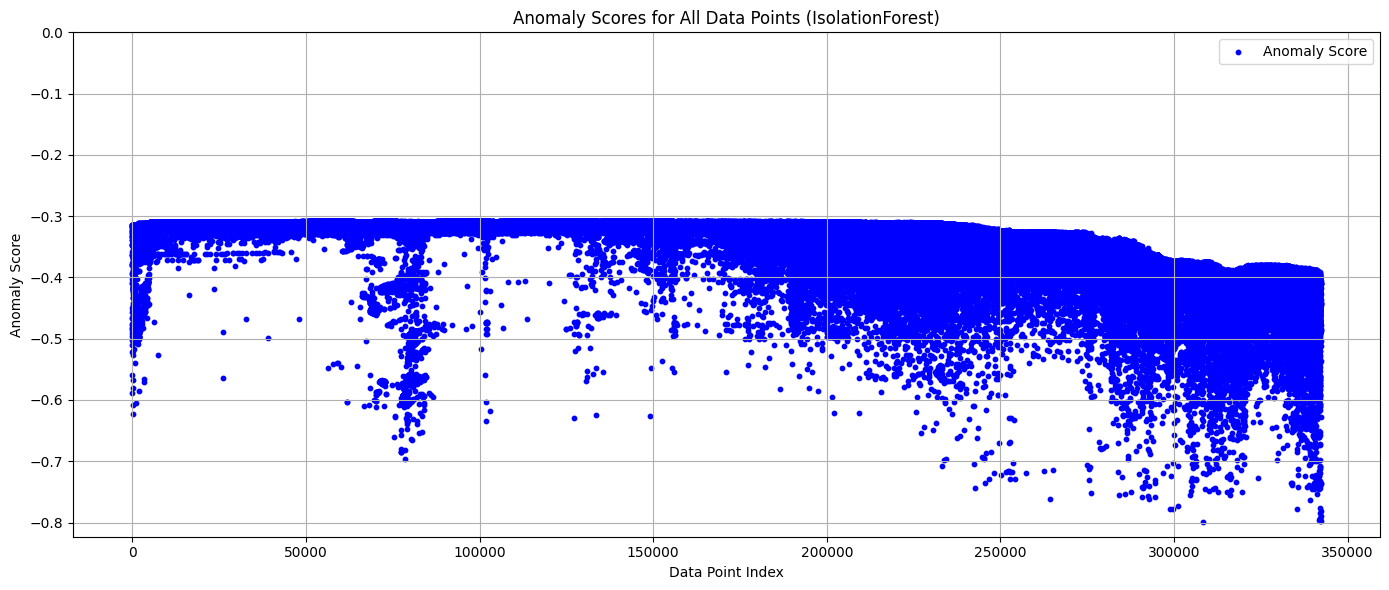

In [15]:
preds_2 = IF.predict(df_2_scaled)
scores_2 = IF.score_samples(df_2_scaled)

df_2_scaled_result = pd.DataFrame()
df_2_scaled_result['prediction'] = preds_2
df_2_scaled_result['anomaly_score'] = scores_2


anomaly_2 = (df_2_scaled_result["prediction"] == -1).sum()
normal_2 = (df_2_scaled_result["prediction"] == 1).sum()

log( f"2.2 Wizualizacja efektu testu na danych Tuesday-workingHours", level=["start","Isolation_forest"])
log(f"Detection distribution anomaly/normal: {anomaly_2 / len(df_2_scaled_result) * 100:.4f}% / {normal_2 / len(df_2_scaled_result) * 100:.4f}%")
log("!!! Wyniki pokazuje dopasowanie contamination (wyciagania wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!")
log(f"Anomaly detected: {anomaly_2}")
log(f"Normal traffic: {normal_2}")

plt.figure(figsize=(14, 6))  # szeroki wykres

plt.scatter(df_2_scaled_result.index, df_2_scaled_result['anomaly_score'], color='blue', label='Anomaly Score', s=10)

plt.title('Anomaly Scores for All Data Points (IsolationForest)')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(top=0)
plt.show()

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    3.9s finished


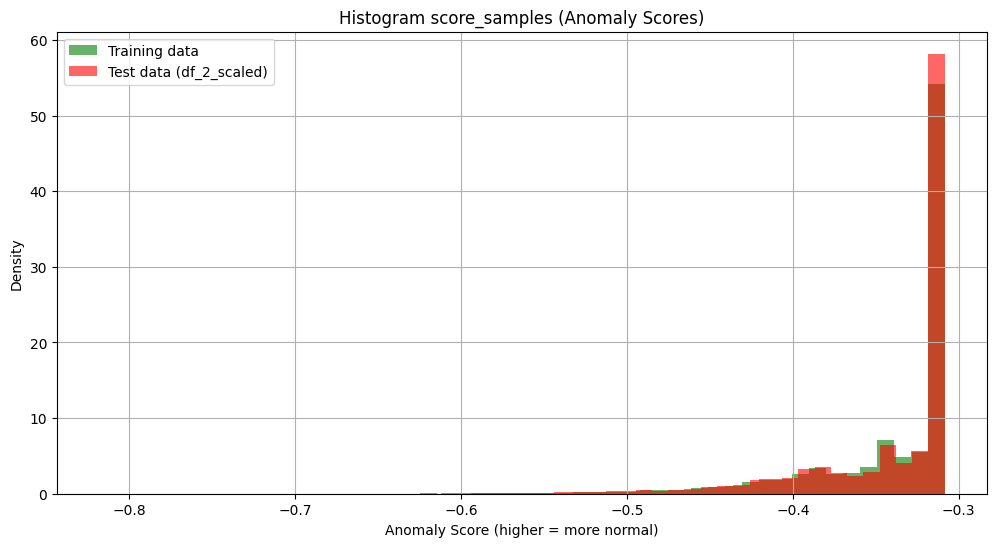

In [16]:
scores_train = IF.score_samples(df_1_scaled)

# score_samples dla danych testowych (z anomaliami)
scores_test = scores_2

plt.figure(figsize=(12,6))

# Histogram dla danych treningowych
plt.hist(scores_train, bins=50, alpha=0.6, label='Training data', color='green', density=True)

# Histogram dla danych testowych
plt.hist(scores_test, bins=50, alpha=0.6, label='Test data (df_2_scaled)', color='red', density=True)

plt.title('Histogram score_samples (Anomaly Scores)')
plt.xlabel('Anomaly Score (higher = more normal)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>2.3 Sprawdzenie dokładniści wytrenowanego modelu na Tuesday-workingHours</div>
</div>

In [17]:
df_2_scaled_result_check = pd.concat([df_2_scaled,df_2_scaled_result, df_2_labels], axis=1)
#print(len(df_2_scaled_result),len(df_2_labels),len(df_2_scaled_result_check))
# print(df_2_scaled_result.index)
# print(df_2_labels.index)
# print(df_2_scaled_result_check.head)
log("2.3 Sprawdzenie dokładniści wytrenowanego modelu na Tuesday-workingHours",level = ["start","Isolation_forest"])
log(f"Number of flows in Tuesday - Working Hours: {len(df_2_scaled_result_check)}")

df_2_real_anomaly_count = (df_2_scaled_result_check["Label"] != "BENIGN").sum()

log("Correct data: ")
log(f"Real number of anomalies in Tuesday - Working Hours: {df_2_real_anomaly_count}")
log(f"Procentage of anomlys in dataset: {df_2_real_anomaly_count / len(df_2_scaled_result_check) * 100:.4f}%")

df_2_predicted_anomaly_count = (df_2_scaled_result_check["prediction"] == -1).sum()

log("Predicted data: ")
log(f"Number of DETECTED anomalies in Tuesday - Working Hours: {df_2_predicted_anomaly_count}")
log(f"Procentage of anomlys in dataset: {df_2_predicted_anomaly_count / len(df_2_scaled_result_check) * 100:.4f}%")

TP = ((df_2_scaled_result_check["Label"] != "BENIGN") & (df_2_scaled_result_check["prediction"] == -1)).sum()
FP = df_2_predicted_anomaly_count - TP
FN = df_2_real_anomaly_count - TP
TN = len(df_2_scaled_result_check) - TP - FP - FN

log(f"\nNumber of correct predictions(TP): {TP}")
log(f"Number of wrong predyctions(FP): {FP}")
log(f"Accuracy of predictions: {((TP + TN) / len(df_2_scaled_result_check)) * 100:.4f}%")
log(f"Sensitivity of predictions: {(TP / df_2_real_anomaly_count) * 100:.4f}%")
log(f"Precision of predictions: {(TP / df_2_predicted_anomaly_count) * 100:.4f}%")

# print("TP: ",TP)
# print("FP: ",FP)
# print("TN: ",TN)
# print("FN: ",FN)

# pd.set_option('display.max_rows', 200)
# print(df_2_scaled_result_check[df_2_scaled_result_check["prediction"] == -1])
# pd.reset_option('display.max_rows')

Isolation_forest
Number of flows in Tuesday - Working Hours: 342225
Correct data: 
Real number of anomalies in Tuesday - Working Hours: 9084
Procentage of anomlys in dataset: 2.6544%
Predicted data: 
Number of DETECTED anomalies in Tuesday - Working Hours: 4131
Procentage of anomlys in dataset: 1.2071%

Number of correct predictions(TP): 2
Number of wrong predyctions(FP): 4129
Accuracy of predictions: 96.1397%
Sensitivity of predictions: 0.0220%
Precision of predictions: 0.0484%


<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>3.1 Wizualizacja efektu testu na danych Wednesday-WorkingHours - Tylko ataki</div>
</div>

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished


Detection distribution anomaly/normal: 80.9159% / 19.0841%
!!! Wyniki pokazuje dopasowanie contamination (wyciagancia wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected: 156069
Normal traffic: 36809


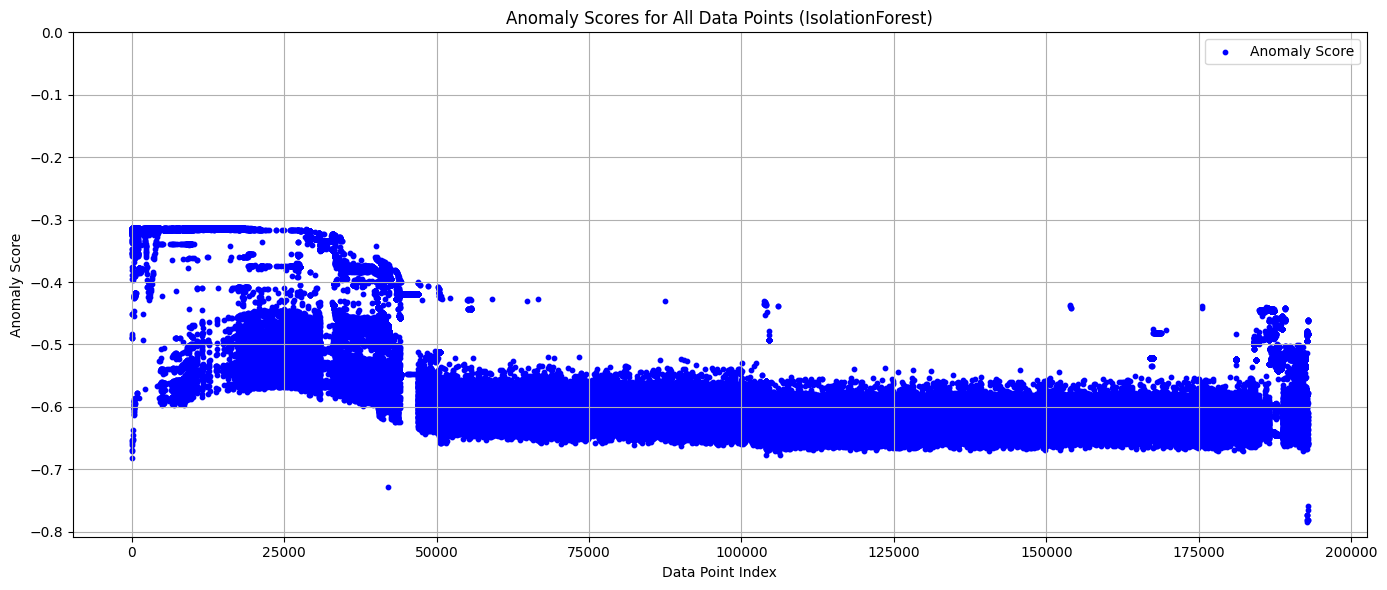

In [18]:
preds_3_5 = IF.predict(df_3_5_scaled)
scores_3_5 = IF.score_samples(df_3_5_scaled)

df_3_5_scaled_result = pd.DataFrame()
df_3_5_scaled_result['prediction'] = preds_3_5
df_3_5_scaled_result['anomaly_score'] = scores_3_5


anomaly_3_5 = (df_3_5_scaled_result["prediction"] == -1).sum()
normal_3_5 = (df_3_5_scaled_result["prediction"] == 1).sum()

print(f"Detection distribution anomaly/normal: {anomaly_3_5 / len(df_3_5_scaled_result) * 100:.4f}% / {normal_3_5 / len(df_3_5_scaled_result) * 100:.4f}%")
print("!!! Wyniki pokazuje dopasowanie contamination (wyciagancia wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!")
print(f"Anomaly detected: {anomaly_3_5}")
print(f"Normal traffic: {normal_3_5}")
plt.figure(figsize=(14, 6))

plt.scatter(df_3_5_scaled_result.index, df_3_5_scaled_result['anomaly_score'], color='blue', label='Anomaly Score', s=10)

plt.title('Anomaly Scores for All Data Points (IsolationForest)')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(top=0)
plt.show()


<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>3.2 Wizualizacja efektu testu na danych i sprawdzenie dokładniści wytrenowanego modelu Wednesday-WorkingHours</div>
</div>


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    5.1s finished


Isolation_Forest
Detection distribution anomaly/normal: 30.3957% / 69.6043%
!!! Wyniki pokazuje dopasowanie contamination (wyciagania wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected: 163315
Normal traffic: 373982


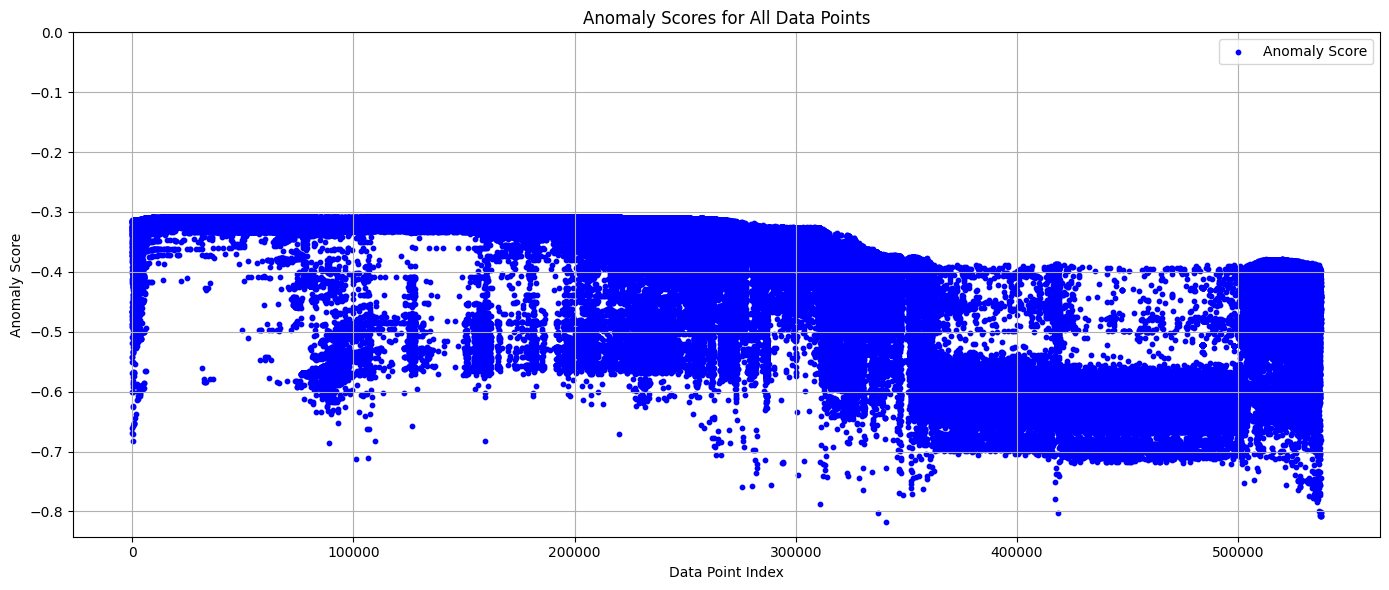

Isolation_Forest
Number of flows in Wednesday-WorkingHours: 537297
Correct data: 
Real number of anomalies in Wednesday-WorkingHours: 192878
Procentage of anomlys in dataset: 35.8978%
Predicted data: 
Number of DETECTED anomalies in Wednesday-WorkingHours: 163315
Procentage of anomlys in dataset: 30.3957%

Number of correct predictions(TP): 156069
Number of wrong predyctions(FP): 7246
Accuracy of predictions: 91.8006%
Sensitivity of predictions: 80.9159%
Precision of predictions: 95.5632%
F - mesure - harmonic-mean of precision and sensitivity: 87.6317%


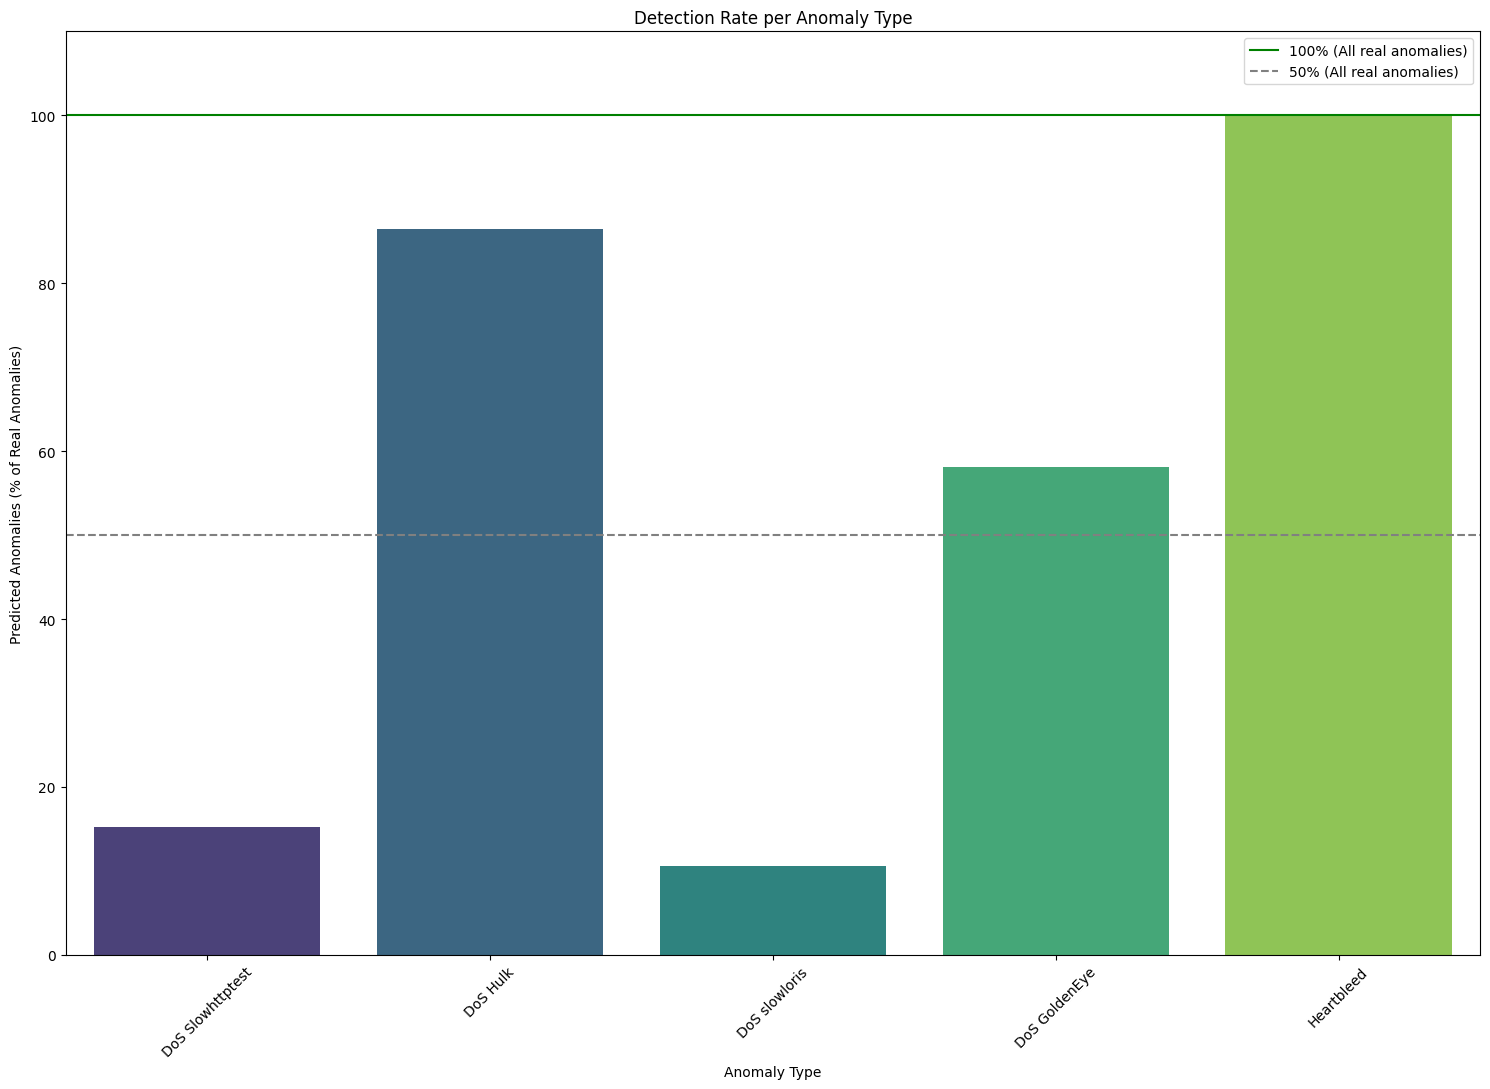

Detection rate by attack type:
Name: DoS Slowhttptest, Detected: 15.2286%
Name: DoS Hulk, Detected: 86.4726%
Name: DoS slowloris, Detected: 10.5909%
Name: DoS GoldenEye, Detected: 58.1558%
Name: Heartbleed, Detected: 100.0%


In [19]:
df_3_scaled_result_check = pd.DataFrame()
df_3_scaled_result_check = test_IF_model(IF, df_3_scaled, df_3_labels, name="Wednesday-WorkingHours")

<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>3.4 Analiza niewyłapanych ataków Wednesday-WorkingHours</div>
</div>

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished


36809 192878


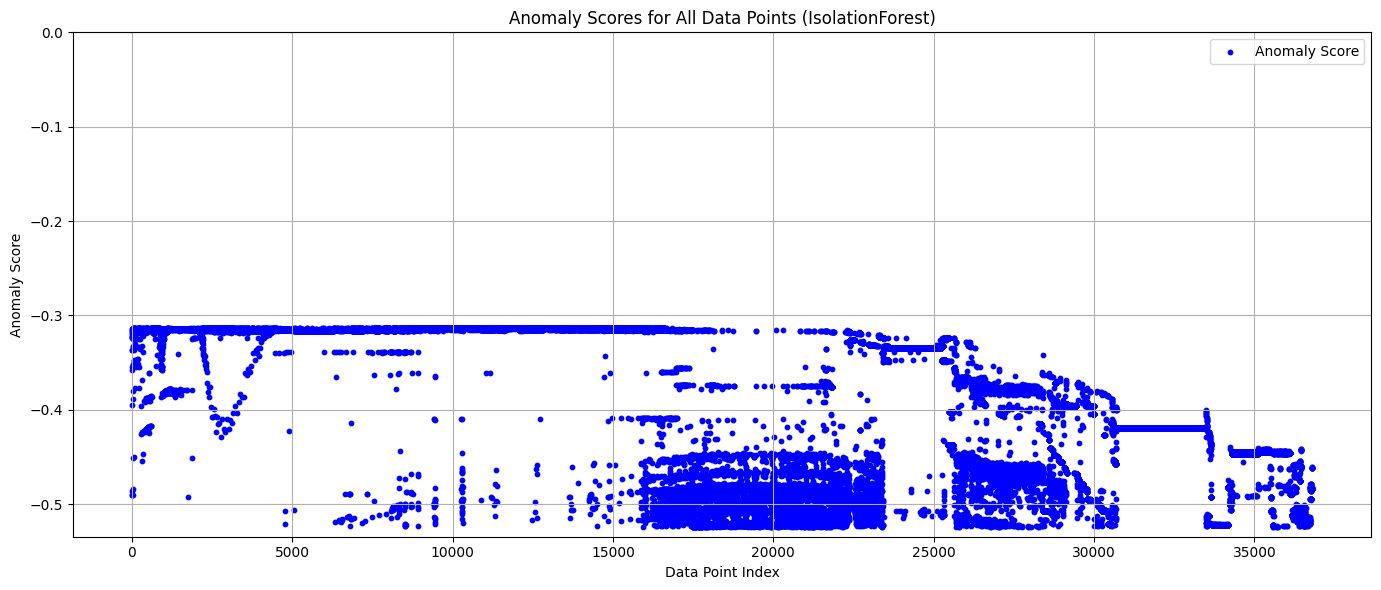

In [20]:

df_3_real_anomaly = df_3_scaled_result_check[df_3_scaled_result_check["Label"] != "BENIGN"].copy()
df_3_real_anomaly = df_3_real_anomaly.reset_index(drop=True)
df_3_real_anomaly_no_label = df_3_real_anomaly.drop(["Label",'prediction','anomaly_score'], axis = 1)

preds_3_real = IF.predict(df_3_real_anomaly_no_label)
scores_3_real = IF.score_samples(df_3_real_anomaly_no_label)


df_3_real_anomaly['prediction'] = preds_3_real
df_3_real_anomaly['anomaly_score'] = scores_3_real

print((df_3_real_anomaly['prediction'] == 1).sum(), len(df_3_real_anomaly))
df_3_real_anomaly = df_3_real_anomaly[df_3_real_anomaly['prediction'] != -1]
df_3_real_anomaly = df_3_real_anomaly.reset_index(drop=True)

plt.figure(figsize=(14, 6))  # szeroki wykres

plt.scatter(df_3_real_anomaly.index, df_3_real_anomaly['anomaly_score'], color='blue', label='Anomaly Score', s=10)

plt.title('Anomaly Scores for All Data Points (IsolationForest)')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(top=0)
plt.show()

<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>4 Sprawdzenie dokładności modelu na Thursday</div>
</div>

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    3.1s finished


Isolation_Forest
Detection distribution anomaly/normal: 1.0484% / 98.9516%
!!! Wyniki pokazuje dopasowanie contamination (wyciagania wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected: 3365
Normal traffic: 317610


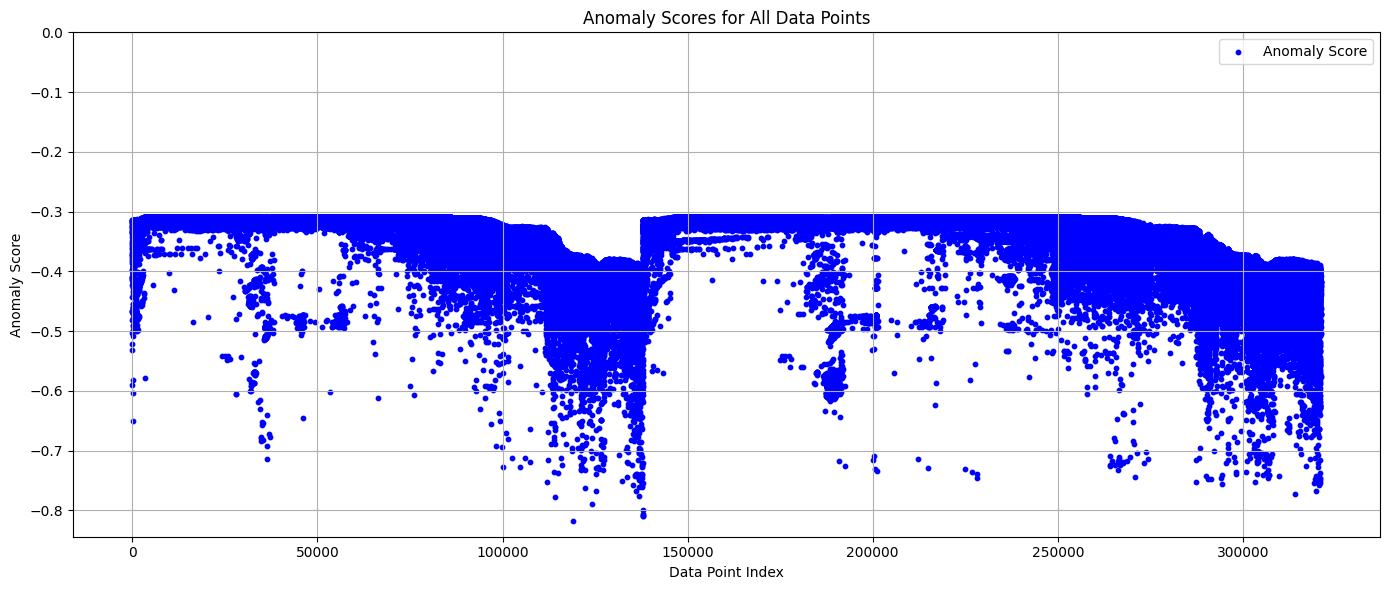

Isolation_Forest
Number of flows in Thursday: 320975
Correct data: 
Real number of anomalies in Thursday: 2135
Procentage of anomlys in dataset: 0.6652%
Predicted data: 
Number of DETECTED anomalies in Thursday: 3365
Procentage of anomlys in dataset: 1.0484%

Number of correct predictions(TP): 107
Number of wrong predyctions(FP): 3258
Accuracy of predictions: 98.3531%
Sensitivity of predictions: 5.0117%
Precision of predictions: 3.1798%
F - mesure - harmonic-mean of precision and sensitivity: 3.8909%


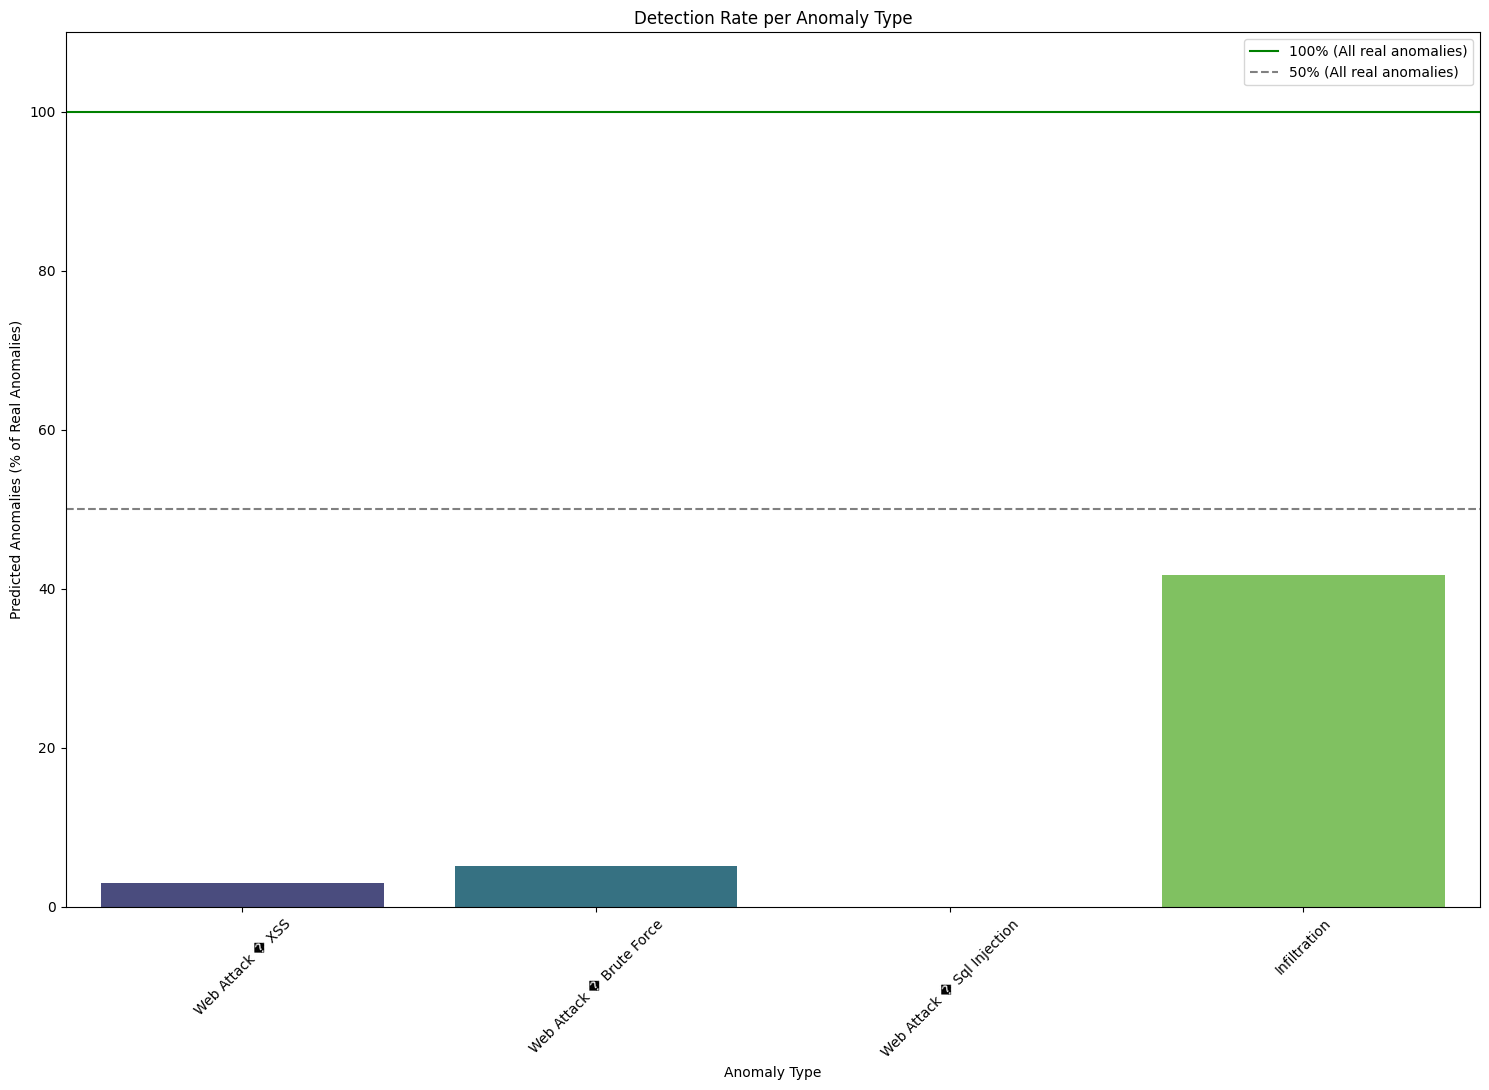

Detection rate by attack type:
Name: Web Attack � XSS, Detected: 2.9141%
Name: Web Attack � Brute Force, Detected: 5.1156%
Name: Web Attack � Sql Injection, Detected: 0.0%
Name: Infiltration, Detected: 41.6667%


In [21]:
df_4_scaled_result_check = test_IF_model(IF,df_4_scaled,df_4_labels, name="Thursday")

<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>5 Sprawdzenie dokładności modelu na Friday</div>
</div>

In [ ]:
df_5_scaled_result_check = test_IF_model(IF,df_5_scaled,df_5_labels, name="Friday")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    4.5s finished


Isolation_Forest
Detection distribution anomaly/normal: 19.5368% / 80.4632%
!!! Wyniki pokazuje dopasowanie contamination (wyciagania wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected: 93092
Normal traffic: 383404


<div style="
    text-align: center;
    font-weight: bold;
    font-size: 52px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-top: 50px;
    margin-bottom: 30px;
    padding: 25px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    border-top: 4px solid #4ec9b0;
    border-bottom: 4px solid #4ec9b0;
    box-shadow: 0 0 100px rgba(78, 201, 176, 0.3), 0 2px 10px rgba(0,0,0,0.6);
    letter-spacing: 1px;
">
   Summary
</div>

In [ ]:
df_scaled = pd.concat([df_2_scaled, df_3_scaled, df_4_scaled, df_5_scaled], ignore_index = True)
df_labels = pd.concat([df_2_labels, df_3_labels, df_4_labels, df_5_labels], ignore_index = True)
print(len(df_scaled))
print(len(df_labels))
df_scaled_result_check = test_IF_model(IF,df_scaled,df_labels, name ="summary",level = "summary")



<div style="text-align: center;color:#66ff7d; font-size: 50px; font-family: 'OCR A Extended', 'Lucida Console', 'Monaco', monospace; margin-top: 20px; line-height: 1.6;">
    df save

</div>

In [ ]:
# df_1_scaled.to_hdf('parsed_data/segmented_CICIDS2017.h5', key='df_1_scaled', mode='w')  # mode='w' to create/overwrite file
# df_2_scaled.to_hdf('parsed_data/segmented_CICIDS2017.h5', key='df_2_scaled', mode='a')  # dane podzielone na segmenty df_1,df_2 itd...
# df_2_labels.to_hdf('parsed_data/segmented_CICIDS2017.h5', key='df_2_labels', mode='a')
# df_3_scaled.to_hdf('parsed_data/segmented_CICIDS2017.h5', key='df_3_scaled', mode='a')
# df_3_labels.to_hdf('parsed_data/segmented_CICIDS2017.h5', key='df_3_labels', mode='a')
# df_4_scaled.to_hdf('parsed_data/segmented_CICIDS2017.h5', key='df_4_scaled', mode='a')
# df_4_labels.to_hdf('parsed_data/segmented_CICIDS2017.h5', key='df_4_labels', mode='a') 
# df_5_scaled.to_hdf('parsed_data/segmented_CICIDS2017.h5', key='df_5_scaled', mode='a')
# df_5_labels.to_hdf('parsed_data/segmented_CICIDS2017.h5', key='df_5_labels', mode='a')


# df_scaled.to_hdf('parsed_data/merged_CICIDS2017.h5', key='df_scaled', mode='w') # merged - wszystkie dane testowe razem
# df_labels.to_hdf('parsed_data/merged_CICIDS2017.h5', key='df_labels', mode='a')

# df_2_scaled_result_check.to_hdf('parsed_data/IF_segmented_CICIDS2017.h5', key='df_2_scaled_result_check', mode='w')  # zapis wyników do h5
# df_3_scaled_result_check.to_hdf('parsed_data/IF_segmented_CICIDS2017.h5', key='df_3_scaled_result_check', mode='a')
# df_4_scaled_result_check.to_hdf('parsed_data/IF_segmented_CICIDS2017.h5', key='df_4_scaled_result_check', mode='a')
# df_5_scaled_result_check.to_hdf('parsed_data/IF_segmented_CICIDS2017.h5', key='df_5_scaled_result_check', mode='a')
# df_scaled_result_check.to_hdf('parsed_data/IF_merged_CICIDS2017.h5', key='df_5_scaled_result_check', mode='w')


##df_scaled.to_hdf('parsed_data/with_repetitions_merged_CICIDS2017.h5', key='df_scaled', mode='w') # repetytions brak drop_duplicated
##df_labels.to_hdf('parsed_data/with_repetitions_merged_CICIDS2017.h5', key='df_labels', mode='a')

# df_1_scaled.to_hdf('parsed_data/min_parsed_segmented_CICIDS2017.h5', key='df_1_scaled', mode='w')  # tu zapisane z minimalnym parsowaniem
# df_2_scaled.to_hdf('parsed_data/min_parsed_segmented_CICIDS2017.h5', key='df_2_scaled', mode='a')  
# df_2_labels.to_hdf('parsed_data/min_parsed_segmented_CICIDS2017.h5', key='df_2_labels', mode='a')
# df_3_scaled.to_hdf('parsed_data/min_parsed_segmented_CICIDS2017.h5', key='df_3_scaled', mode='a')
# df_3_labels.to_hdf('parsed_data/min_parsed_segmented_CICIDS2017.h5', key='df_3_labels', mode='a')
# df_4_scaled.to_hdf('parsed_data/min_parsed_segmented_CICIDS2017.h5', key='df_4_scaled', mode='a')
# df_4_labels.to_hdf('parsed_data/min_parsed_segmented_CICIDS2017.h5', key='df_4_labels', mode='a') 
# df_5_scaled.to_hdf('parsed_data/min_parsed_segmented_CICIDS2017.h5', key='df_5_scaled', mode='a')
# df_5_labels.to_hdf('parsed_data/min_parsed_segmented_CICIDS2017.h5', key='df_5_labels', mode='a')

# df_scaled.to_hdf('parsed_data/min_parsed_merged_CICIDS2017.h5', key='df_scaled', mode='w') # merged - wszystkie dane testowe razem z minimalnym parsowaniem
# df_labels.to_hdf('parsed_data/min_parsed_merged_CICIDS2017.h5', key='df_labels', mode='a')
print("Data saved")

In [ ]:
print(df_4_scaled.isna().any(axis=1).sum())